# Machine Learning / Leakage + Train/Test (Telco Churn)

Amaç:
- Train/Test split mantığı
- Data leakage (en yaygın hata)
- Pipeline ile doğru kurulum
- Baseline model (model yokken performans)
- (Bonus) Confusion Matrix ile hata tiplerini görme

Dataset:
- `WA_Fn-UseC_-Telco-Customer-Churn.csv`


## Kurulum


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 140)
sns.set_theme()

print("Hazır!")


Hazır!


## 1) Veriyi yükle


In [ ]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2) Hedef (y) ve hızlı veri hatırlatma


In [ ]:
df = df.copy()
df["Churn_flag"] = (df["Churn"] == "Yes").astype(int)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0)

print("Churn dağılımı:")
print(df["Churn"].value_counts())
print("\nChurn oranı:", round(df["Churn_flag"].mean(), 3))


Churn dağılımı:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn oranı: 0.265


## 3) X ve y ayırma + Train/Test split (customerID hariç!)


In [ ]:
drop_cols = ["Churn", "Churn_flag", "customerID"]
X = df.drop(columns=drop_cols, errors="ignore")
y = df["Churn_flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (5634, 19) Test: (1409, 19)


## 4) Baseline (Model yok!): Herkese 'Churn=No' de


In [ ]:
pred_base = np.zeros_like(y_test)

print("Baseline Accuracy:", round(accuracy_score(y_test, pred_base), 4))
print("Baseline F1:", round(f1_score(y_test, pred_base), 4))


Baseline Accuracy: 0.7346
Baseline F1: 0.0


## 5) Doğru yaklaşım: Pipeline (Leakage'i engeller)


In [ ]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ]
)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=600))
])

pipe.fit(X_train, y_train)

proba = pipe.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("PIPE Accuracy:", round(accuracy_score(y_test, pred), 4))
print("PIPE F1:", round(f1_score(y_test, pred), 4))


PIPE Accuracy: 0.8055
PIPE F1: 0.604


## 6) Confusion Matrix


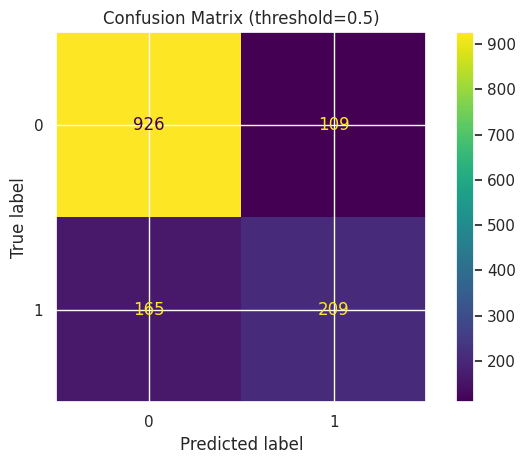

In [ ]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d")
plt.title("Confusion Matrix (threshold=0.5)")
plt.tight_layout()
plt.show()


## 7) Tahmin tablosu (ilk 15 kayit)


In [ ]:
out = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": pred,
    "proba_churn": np.round(proba, 3)
})
out.head(15)


,y_true,y_pred,proba_churn
0,0,0,0.046
1,0,1,0.684
2,0,0,0.059
3,0,0,0.402
4,0,0,0.021
5,0,1,0.603
6,0,0,0.448
7,0,0,0.130
8,0,0,0.003
9,1,0,0.395


## 8) Leakage notu + bariz leakage örneği


Not:
- Scaler/OneHot gibi işlemler tüm veriyle fit edilince her zaman çok büyük skor sıçraması görmeyebilirsin.
- Yine de prensip yanlıştır.

Asağıdaki örnek: hedef sütunu yanlışlıkla X'e girerse skor sahte şekilde çok yükselir.


In [ ]:
# BARIZ leakage: 'Churn' sütunu X içinde kalırsa
X_bad = df.drop(columns=["Churn_flag"], errors="ignore")  # Churn string burada kaldığı için tehlikeli
y_bad = df["Churn_flag"]

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bad, y_bad, test_size=0.2, random_state=42, stratify=y_bad
)

cat_cols_bad = Xb_train.select_dtypes(include=["object"]).columns.tolist()
num_cols_bad = Xb_train.select_dtypes(exclude=["object"]).columns.tolist()

prep_bad = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols_bad),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols_bad),
])

pipe_bad = Pipeline([("prep", prep_bad), ("model", LogisticRegression(max_iter=600))])
pipe_bad.fit(Xb_train, yb_train)
pred_bad = pipe_bad.predict(Xb_test)

print("BARİZ LEAKAGE Accuracy:", round(accuracy_score(yb_test, pred_bad), 4))
print("BARİZ LEAKAGE F1:", round(f1_score(yb_test, pred_bad), 4))


BARİZ LEAKAGE Accuracy: 1.0
BARİZ LEAKAGE F1: 1.0
